# loading libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pathlib
import darts
from darts import TimeSeries
import matplotlib.pyplot as plt
from tqdm import tqdm
from darts.dataprocessing.transformers.scaler import Scaler

# Helping Functions


In [2]:
import numpy as np


def calculate_metrics(actual, predicted):
    # Convert inputs to numpy arrays for easier calculations
    actual = np.array(actual)
    predicted = np.array(predicted)

    # Calculate individual metrics
    mae = np.mean(np.abs(predicted - actual))
    rmse = np.sqrt(np.mean((predicted - actual) ** 2))
    mape = np.mean(np.abs((predicted - actual) / actual)) * 100
    mse = np.mean((predicted - actual) ** 2)

    metrics = {"MAE": mae, "RMSE": rmse, "MAPE": mape, "MSE": mse}

    return metrics

# Data Reading 😶

In [3]:
fileName = "amazon"
df = pd.read_csv(f"../ProcessedData/{fileName}.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,year,month,day_of_month,day_of_week,day_name
0,2018-01-02,58.599998,59.500000,58.525501,59.450500,59.450500,53890000.0,2018,1,2,1,Tuesday
1,2018-01-03,59.415001,60.274502,59.415001,60.209999,60.209999,62176000.0,2018,1,3,2,Wednesday
2,2018-01-04,60.250000,60.793499,60.233002,60.479500,60.479500,60442000.0,2018,1,4,3,Thursday
3,2018-01-05,60.875500,61.457001,60.500000,61.457001,61.457001,70894000.0,2018,1,5,4,Friday
4,2018-01-06,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,2018,1,6,5,Saturday


In [4]:
df = df[["Date", "Close"]]
df = df.drop_duplicates()
df.head()

,Date,Close
0,2018-01-02,59.450500
1,2018-01-03,60.209999
2,2018-01-04,60.479500
3,2018-01-05,61.457001
4,2018-01-06,0.000000


## Spliting Data into Training & Testing Data

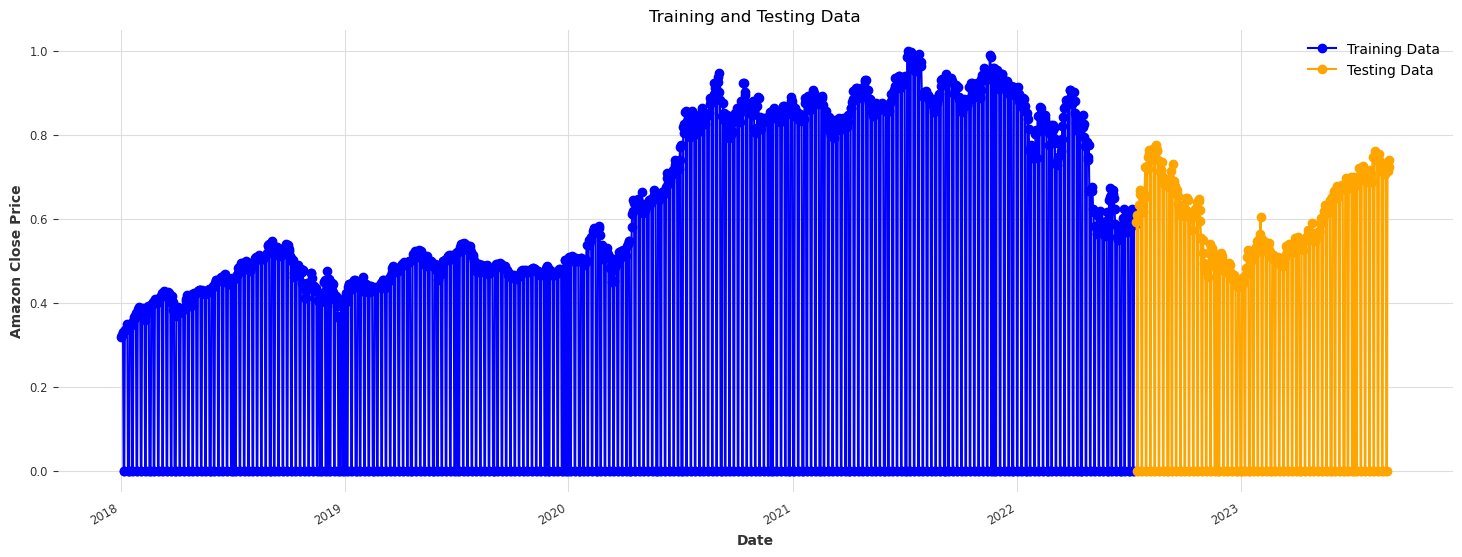

In [5]:
from darts import TimeSeries
import numpy as np
import matplotlib.pyplot as plt

# Assuming df is your DataFrame containing daily data
series = TimeSeries.from_dataframe(
    df, "Date", "Close", freq="1D", fill_missing_dates=True, fillna_value=0
)


split_point = 0.80

train_series, test_series = series.split_after(split_point)

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train_series)
test_transformed = transformer.transform(test_series)
series_transformed = transformer.transform(series)


# Set the figure size and style
plt.figure(figsize=(18, 6))
# Plot the training and testing data
train_transformed.plot(label="Training Data", color="blue", linewidth=1.5, marker="o")
test_transformed.plot(label="Testing Data", color="orange", linewidth=1.5, marker="o")

# Add title and labels
plt.title("Training and Testing Data")
plt.xlabel("Date")
plt.ylabel("Amazon Close Price")

# Add grid lines
plt.grid(True)

# Add legend
plt.legend()

# Display the plot
plt.show()

# LSTM-RNN


In [ ]:
from darts.models.forecasting.rnn_model import RNNModel


rnn_model = RNNModel(
    model="LSTM",
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=300,
    optimizer_kwargs={"lr": 1e-3},
    model_name="StoreNBR",
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    input_chunk_length=14,
    force_reset=True,
    save_checkpoints=True,
)
rnn_model.fit(train_transformed)

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm


# Function to predict and evaluate
def predict_and_evaluate(
    window_size,
    prediction_horizon,
    slide_step,
    test_series,
    model,
    result_plot_path,
    transformer,
):
    num_predictions = len(test_series) - window_size - prediction_horizon + 1

    meta_information_evaluation = {
        "Iterations": [],
        "MAE": [],
        "RMSE": [],
        "MAPE": [],
        "MSE": [],
        "input_window_size": [],
        "horizon": [],
        "stride": [],
    }

    try:
        for i in tqdm(range(0, num_predictions, slide_step)):
            input_window = test_series[i : i + window_size]
            ground_truth = test_series[
                i + window_size : i + window_size + prediction_horizon
            ]
            forecast = model.predict(n=prediction_horizon, series=input_window)

            input_window = transformer.inverse_transform(input_window)
            ground_truth = transformer.inverse_transform(ground_truth)
            forecast = transformer.inverse_transform(forecast)
            # print(ground_truth)

            # print('1:Actual:', ground_truth.values().flatten().tolist())
            # print('2:Predicted:', predicted.values().flatten().tolist())
            # print('3:Input:',input_window.values().flatten().tolist())

            actual = ground_truth.values().flatten().tolist()
            predicted = forecast.values().flatten().tolist()

            metrics = calculate_metrics(actual, predicted)

            meta_information_evaluation["Iterations"].append(i)
            meta_information_evaluation["MAE"].append(metrics["MAE"])
            meta_information_evaluation["RMSE"].append(metrics["RMSE"])
            meta_information_evaluation["MAPE"].append(metrics["MAPE"])
            meta_information_evaluation["MSE"].append(metrics["MSE"])
            meta_information_evaluation["input_window_size"].append(window_size)
            meta_information_evaluation["horizon"].append(prediction_horizon)
            meta_information_evaluation["stride"].append(slide_step)

            bypass_information = {
                "slide_step": slide_step,
                "window_size": window_size,
                "horizon": prediction_horizon,
            }
            create_plots(
                input_window,
                forecast,
                ground_truth,
                result_plot_path,
                bypass_information,
            )

        evalaution_df = pd.DataFrame.from_dict(meta_information_evaluation)

        return evalaution_df

    except Exception as e:
        print("Error Occurred in fuction predict_and_evaluate():", e)
        evalaution_df = pd.DataFrame.from_dict(meta_information_evaluation)

        return evalaution_df


# Function to create plots
def create_plots(
    input_window, forecast, ground_truth, result_plot_path, bypass_information
):
    plt.figure(figsize=(30, 6))
    input_window.plot(label="Input Data", marker="o")
    forecast.plot(label="Predicted", marker="o")
    ground_truth.plot(label="Ground Truth", marker="o")

    combined_time_index = input_window.time_index.append(forecast.time_index).append(
        ground_truth.time_index
    )
    starting_date_of_input_data = input_window.time_index[0].strftime("%Y-%m-%d")
    ending_date_of_input_data = input_window.time_index[-1].strftime("%Y-%m-%d")
    starting_date_predicted = forecast.time_index[0].strftime("%Y-%m-%d")
    ending_date_of_predicted = forecast.time_index[-1].strftime("%Y-%m-%d")

    plt.xticks(
        combined_time_index, combined_time_index.strftime("%Y-%m-%d"), rotation=90
    )
    plt.title(
        f"Results of Input Data from {starting_date_of_input_data} to {ending_date_of_input_data} & Evaluation on from {starting_date_predicted} to {ending_date_of_predicted}",
        fontsize=16,
    )
    plt.ylabel("Amazon Close Price", fontsize=14)
    plt.xlabel("Dates", fontsize=14)
    plt.legend()

    plot_filename = f"{result_plot_path}/{bypass_information['window_size']}_{bypass_information['horizon']}_{bypass_information['slide_step']}.png"
    plt.savefig(plot_filename)
    plt.close()
    # plt.show()

# Model Evaluation

In [ ]:
def model_evaluation(model_name, model_object, test_series, transformer, FileName):
    result_path = f"../ProcessedData/Results/{model_name}/{FileName}"
    result_plot_path = (
        f"../ProcessedData/Results/{model_name}/{FileName}/{model_name}_Plots"
    )
    os.makedirs(result_path, exist_ok=True)
    os.makedirs(result_plot_path, exist_ok=True)

    # Set your parameters
    window_sizes = [30, 45, 90]
    prediction_horizons = [15, 30, 35]
    slide_steps = [5, 10, 15]

    test_series = test_series
    model = model_object

    for window_size in window_sizes:
        for prediction_horizon in prediction_horizons:
            for slide_step in slide_steps:
                print(
                    f"Iteration : Window size : {window_size} Horizan: {prediction_horizon}, Stride : {slide_step}"
                )
                evaluation_df = predict_and_evaluate(
                    window_size,
                    prediction_horizon,
                    slide_step,
                    test_series,
                    model,
                    result_plot_path,
                    transformer,
                )
                evaluation_df.to_csv(
                    f"{result_path}/window_size_{window_size}_horizon_{prediction_horizon}_stride_{slide_step}.csv",
                    index=False,
                )

                print(
                    f"Window_size_{window_size}_prediction_horizon_{prediction_horizon}_slide_step_{slide_step} - Evaluation completed."
                )
        #         break
        #     break
        # break

## RNN-LSTM

In [11]:
model_name = "RNN_LSTM"
FileName = fileName
model_object = rnn_model
test_series = test_transformed
model_evaluation(model_name, model_object, test_series, transformer, FileName)

 28%|██▊       | 16/58 [00:25<01:32,  2.19s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.39it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 29%|██▉       | 17/58 [00:28<01:39,  2.43s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 36.84it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 31%|███       | 18/58 [00:31<01:38,  2.45s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 38.46it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 33%|███▎      | 19/58 [00:32<01:26,  2.21s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 56.98it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 34%|███▍      | 20/58 [00:34<01:13,  1.92s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 37.32it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 36%|███▌      | 21/58 [00:35<01:03,  1.72s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.42it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 38%|███▊      | 22/58 [00:36<00:56,  1.56s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.69it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 40%|███▉      | 23/58 [00:37<00:52,  1.49s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.42it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 41%|████▏     | 24/58 [00:39<00:47,  1.40s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.41it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 43%|████▎     | 25/58 [00:40<00:43,  1.33s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.71it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 45%|████▍     | 26/58 [00:41<00:41,  1.30s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 52.75it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 47%|████▋     | 27/58 [00:42<00:39,  1.29s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.03it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 48%|████▊     | 28/58 [00:43<00:38,  1.28s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.01it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 50%|█████     | 29/58 [00:45<00:35,  1.24s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.42it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 52%|█████▏    | 30/58 [00:46<00:33,  1.20s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.43it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 53%|█████▎    | 31/58 [00:47<00:32,  1.19s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.94it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 55%|█████▌    | 32/58 [00:48<00:31,  1.20s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.75it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 57%|█████▋    | 33/58 [00:49<00:29,  1.17s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.57it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 59%|█████▊    | 34/58 [00:50<00:28,  1.19s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.76it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 60%|██████    | 35/58 [00:52<00:27,  1.22s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.14it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 62%|██████▏   | 36/58 [00:53<00:26,  1.21s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.78it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 64%|██████▍   | 37/58 [00:54<00:25,  1.23s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.59it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 66%|██████▌   | 38/58 [00:55<00:24,  1.21s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.09it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 67%|██████▋   | 39/58 [00:57<00:23,  1.21s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 58.11it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 69%|██████▉   | 40/58 [00:58<00:22,  1.22s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.95it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 71%|███████   | 41/58 [00:59<00:20,  1.23s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.82it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 72%|███████▏  | 42/58 [01:00<00:19,  1.22s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.04it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 74%|███████▍  | 43/58 [01:02<00:18,  1.26s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 57.28it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 76%|███████▌  | 44/58 [01:03<00:17,  1.25s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.63it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 78%|███████▊  | 45/58 [01:04<00:15,  1.21s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.67it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 79%|███████▉  | 46/58 [01:05<00:14,  1.24s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.76it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 81%|████████  | 47/58 [01:07<00:13,  1.24s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.81it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 83%|████████▎ | 48/58 [01:08<00:12,  1.26s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.23it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 84%|████████▍ | 49/58 [01:09<00:11,  1.27s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.28it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 86%|████████▌ | 50/58 [01:11<00:10,  1.30s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.42it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 88%|████████▊ | 51/58 [01:12<00:09,  1.33s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 53.17it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 90%|████████▉ | 52/58 [01:13<00:07,  1.29s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.68it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 91%|█████████▏| 53/58 [01:15<00:06,  1.39s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 29.61it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 93%|█████████▎| 54/58 [01:17<00:06,  1.61s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 30.12it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 95%|█████████▍| 55/58 [01:19<00:05,  1.79s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 37.06it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 97%|█████████▋| 56/58 [01:21<00:03,  1.78s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.61it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 98%|█████████▊| 57/58 [01:23<00:01,  1.81s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 54.65it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


100%|██████████| 58/58 [01:24<00:00,  1.46s/it]


Window_size_90_prediction_horizon_35_slide_step_5 - Evaluation completed.
Iteration : Window size : 90 Horizan: 35, Stride : 10


  0%|          | 0/29 [00:00<?, ?it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 40.47it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


  3%|▎         | 1/29 [00:01<00:47,  1.70s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 48.32it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


  7%|▋         | 2/29 [00:03<00:45,  1.70s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 40.30it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 10%|█         | 3/29 [00:05<00:44,  1.72s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 50.92it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 14%|█▍        | 4/29 [00:06<00:39,  1.57s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 53.86it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 17%|█▋        | 5/29 [00:08<00:39,  1.64s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.80it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 21%|██        | 6/29 [00:10<00:42,  1.83s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 44.14it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 24%|██▍       | 7/29 [00:11<00:37,  1.70s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 51.15it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 28%|██▊       | 8/29 [00:13<00:35,  1.71s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 40.35it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 31%|███       | 9/29 [00:15<00:34,  1.70s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 59.99it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 34%|███▍      | 10/29 [00:16<00:31,  1.66s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 27.26it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 38%|███▊      | 11/29 [00:18<00:30,  1.67s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 50.28it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 41%|████▏     | 12/29 [00:19<00:26,  1.56s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 50.39it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 45%|████▍     | 13/29 [00:21<00:23,  1.49s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 55.37it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 48%|████▊     | 14/29 [00:22<00:21,  1.44s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.74it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 52%|█████▏    | 15/29 [00:23<00:19,  1.40s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 49.88it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 55%|█████▌    | 16/29 [00:25<00:17,  1.37s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 44.69it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 59%|█████▊    | 17/29 [00:26<00:16,  1.37s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.85it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 62%|██████▏   | 18/29 [00:27<00:14,  1.33s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.32it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 66%|██████▌   | 19/29 [00:29<00:13,  1.34s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 44.82it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 69%|██████▉   | 20/29 [00:30<00:11,  1.31s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.35it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 72%|███████▏  | 21/29 [00:31<00:10,  1.34s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 42.93it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 76%|███████▌  | 22/29 [00:33<00:10,  1.57s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.10it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 79%|███████▉  | 23/29 [00:35<00:09,  1.60s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.23it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 83%|████████▎ | 24/29 [00:37<00:07,  1.59s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.21it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 86%|████████▌ | 25/29 [00:38<00:06,  1.54s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.38it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 90%|████████▉ | 26/29 [00:39<00:04,  1.47s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.70it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 93%|█████████▎| 27/29 [00:41<00:02,  1.39s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 58.29it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 97%|█████████▋| 28/29 [00:42<00:01,  1.34s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.44it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


100%|██████████| 29/29 [00:43<00:00,  1.50s/it]


Window_size_90_prediction_horizon_35_slide_step_10 - Evaluation completed.
Iteration : Window size : 90 Horizan: 35, Stride : 15


  0%|          | 0/20 [00:00<?, ?it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.77it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


  5%|▌         | 1/20 [00:01<00:22,  1.19s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.50it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 10%|█         | 2/20 [00:02<00:20,  1.16s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.71it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 15%|█▌        | 3/20 [00:03<00:19,  1.14s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 59.66it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 20%|██        | 4/20 [00:04<00:18,  1.18s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 53.09it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 25%|██▌       | 5/20 [00:05<00:18,  1.20s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.08it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 30%|███       | 6/20 [00:07<00:16,  1.19s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 53.06it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 35%|███▌      | 7/20 [00:08<00:15,  1.23s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 51.69it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 40%|████      | 8/20 [00:09<00:14,  1.24s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.38it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 45%|████▌     | 9/20 [00:10<00:13,  1.26s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 51.98it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 50%|█████     | 10/20 [00:12<00:12,  1.25s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.00it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 55%|█████▌    | 11/20 [00:13<00:11,  1.24s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 44.30it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 60%|██████    | 12/20 [00:14<00:09,  1.23s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.98it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 65%|██████▌   | 13/20 [00:15<00:08,  1.25s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.64it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 70%|███████   | 14/20 [00:17<00:07,  1.21s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 51.80it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 75%|███████▌  | 15/20 [00:18<00:05,  1.18s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 58.15it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 80%|████████  | 16/20 [00:19<00:04,  1.18s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 56.79it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 85%|████████▌ | 17/20 [00:20<00:03,  1.22s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 55.95it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 90%|█████████ | 18/20 [00:25<00:04,  2.34s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.67it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


 95%|█████████▌| 19/20 [00:26<00:01,  1.99s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.60it/s]

/tmp/ipykernel_17169/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100


100%|██████████| 20/20 [00:28<00:00,  1.41s/it]

Window_size_90_prediction_horizon_35_slide_step_15 - Evaluation completed.


# Evaluate Metrics

In [10]:
import pandas as pd
import glob


def aggregate_evaluation_results(file_pattern):
    eval_dict = {
        "window_size": [],
        "horizan": [],
        "stride": [],
        "AVG_MAE": [],
        "AVG_MSE": [],
        "AVG_RMSE": [],
        "AVG_MAPE": [],
    }

    paths = glob.glob(file_pattern)

    for path in paths:
        window_size = path.split("/")[-1].split("_")[2]
        horizan = path.split("/")[-1].split("_")[4]
        stride = path.split("/")[-1].split("_")[6].split(".")[0]

        df = pd.read_csv(path)
        eval_dict["window_size"].append(window_size)
        eval_dict["horizan"].append(horizan)
        eval_dict["stride"].append(stride)

        eval_dict["AVG_MAE"].append(df["MAE"].mean())
        eval_dict["AVG_MSE"].append(df["MSE"].mean())
        eval_dict["AVG_RMSE"].append(df["RMSE"].mean())
        eval_dict["AVG_MAPE"].append(df["MAPE"].mean())

    eval_df = pd.DataFrame.from_dict(eval_dict)
    eval_df = eval_df.dropna()
    eval_df.sort_values(
        ["window_size", "horizan", "stride"], inplace=True, ascending=True
    )

    return eval_df


# Example usage
file_pattern = "../ProcessedData/Results/RNN_LSTM/amazon/*.csv"
result_df = aggregate_evaluation_results(file_pattern)
result_df = result_df[['window_size','horizan','stride','AVG_MAE','AVG_MSE','AVG_RMSE']]


In [11]:
for name , group in result_df.groupby(['window_size','horizan']):
    print(name)
    display(group)    

('30', '15')


,window_size,horizan,stride,AVG_MAE,AVG_MSE,AVG_RMSE
5,30,15,10,14.175357,466.923542,20.170396
15,30,15,15,13.646224,438.491092,19.341372
23,30,15,5,14.081347,468.335601,20.131165


('30', '30')


,window_size,horizan,stride,AVG_MAE,AVG_MSE,AVG_RMSE
14,30,30,10,19.441523,728.069884,26.141963
26,30,30,15,19.078430,704.469813,25.595959
10,30,30,5,19.326768,726.858391,26.073015


('30', '35')


,window_size,horizan,stride,AVG_MAE,AVG_MSE,AVG_RMSE
16,30,35,10,20.696355,802.559319,27.509433
2,30,35,15,20.559751,789.369995,27.183252
3,30,35,5,20.647203,805.500438,27.501353


('45', '15')


,window_size,horizan,stride,AVG_MAE,AVG_MSE,AVG_RMSE
8,45,15,10,14.112305,478.886117,20.320478
20,45,15,15,13.596529,443.592109,19.406501
18,45,15,5,14.146417,471.109916,20.178247


('45', '30')


,window_size,horizan,stride,AVG_MAE,AVG_MSE,AVG_RMSE
19,45,30,10,19.187619,723.072410,25.928776
11,45,30,15,18.991450,700.510555,25.482514
9,45,30,5,19.289531,723.065201,25.965538


('45', '35')


,window_size,horizan,stride,AVG_MAE,AVG_MSE,AVG_RMSE
4,45,35,10,20.593965,807.252126,27.444969
7,45,35,15,20.364342,779.042576,26.971859
13,45,35,5,20.593218,801.348170,27.392493


('90', '15')


,window_size,horizan,stride,AVG_MAE,AVG_MSE,AVG_RMSE
12,90,15,10,14.196799,464.108196,20.144555
25,90,15,15,13.897697,449.440540,19.583044
24,90,15,5,14.362293,483.695778,20.525984


('90', '30')


,window_size,horizan,stride,AVG_MAE,AVG_MSE,AVG_RMSE
1,90,30,10,19.463848,735.724252,26.190225
22,90,30,15,19.186927,714.639705,25.681736
17,90,30,5,19.537421,746.768989,26.362358


('90', '35')


,window_size,horizan,stride,AVG_MAE,AVG_MSE,AVG_RMSE
0,90,35,10,20.698181,810.671640,27.567006
6,90,35,15,20.647915,800.626608,27.297904
21,90,35,5,20.870919,829.058918,27.833668
